In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Set random seed for reproducibility
np.random.seed(67)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [88]:
# Get device for training
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [89]:
# Load dataset
housing = fetch_california_housing()
X, Y = housing.data, housing.target
num_classes = len(np.unique(Y))
print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {num_classes}")
print(f"Features per sample: {X.shape[1]}")

Dataset shape: (20640, 8)
Number of classes: 3842
Features per sample: 8


In [90]:
# explore dataset
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [91]:
# Data processing parameters
data_portions = (0.6,0.2,0.2)
training_portion, validation_portion, test_portion = data_portions
# Normalize
validation_portion = validation_portion / (validation_portion+training_portion)

In [92]:
# Normalize inputs
# X_mean = X.mean(axis=0)
# X_std = X.std(axis=0)
# X_normalized = (X - X_mean) / X_std

# Split into training and test sets
num_samples = X.shape[0]
X_temp, X_test, Y_temp, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=20
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.25, random_state=20
)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

train_loader = DataLoader(list(zip(X_train, Y_train)), batch_size=32, shuffle=True)
val_loader = DataLoader(list(zip(X_val, Y_val)), batch_size=32, shuffle=False)
test_loader = DataLoader(list(zip(X_test, Y_test)), batch_size=32, shuffle=False)

In [140]:
class Net(nn.Module):

    def __init__(self, input_size, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size,8),
            nn.ReLU(),
            # nn.Linear(16,16),
            # nn.ReLU(),
            nn.Linear(8,output_size)
        )
    
    def forward(self,x):
        return self.net(x)

In [107]:
def train_model(model, X_train, Y_train, X_val, Y_val, num_epochs, batch_size, learning_rate):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for  inputs, labels in train_loader:
            inputs, labels = inputs.float().to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_loss = epoch_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.float().to(device), labels.float().to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return history

In [95]:
# Configure model
input_size = X_train.shape[1]
output_size = 1  # Regression output

In [141]:
model = Net(input_size, output_size).to(device)

history = train_model(model, X_train=X_train, Y_train=Y_train, X_val=X_val, Y_val=Y_val, num_epochs=500, 
                      batch_size=32, learning_rate=0.001)

# Evaluate on test set
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).to(device).view(-1, 1)
    Y_pred = model(X_test_tensor)
    test_loss = nn.MSELoss()(Y_pred, Y_test_tensor)
    print(f'Test MSE Loss: {test_loss.item():.4f}')

Epoch [1/500], Train Loss: 3.7232, Val Loss: 1.3290
Epoch [2/500], Train Loss: 0.8898, Val Loss: 0.6972
Epoch [3/500], Train Loss: 0.6583, Val Loss: 0.5719
Epoch [4/500], Train Loss: 0.5580, Val Loss: 0.4931
Epoch [5/500], Train Loss: 0.4951, Val Loss: 0.4491
Epoch [6/500], Train Loss: 0.4599, Val Loss: 0.4282
Epoch [7/500], Train Loss: 0.4423, Val Loss: 0.4134
Epoch [8/500], Train Loss: 0.4319, Val Loss: 0.4127
Epoch [9/500], Train Loss: 0.4245, Val Loss: 0.3979
Epoch [10/500], Train Loss: 0.4174, Val Loss: 0.3993
Epoch [11/500], Train Loss: 0.4139, Val Loss: 0.3911
Epoch [12/500], Train Loss: 0.4067, Val Loss: 0.3882
Epoch [13/500], Train Loss: 0.4034, Val Loss: 0.3855
Epoch [14/500], Train Loss: 0.4010, Val Loss: 0.3814
Epoch [15/500], Train Loss: 0.3964, Val Loss: 0.3805
Epoch [16/500], Train Loss: 0.3946, Val Loss: 0.3777
Epoch [17/500], Train Loss: 0.3925, Val Loss: 0.3783
Epoch [18/500], Train Loss: 0.3893, Val Loss: 0.3731
Epoch [19/500], Train Loss: 0.3881, Val Loss: 0.3743
Ep

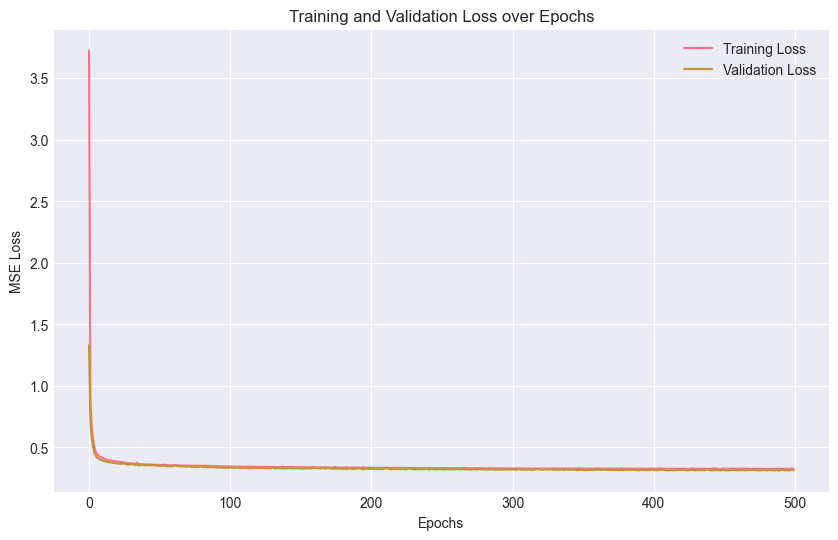

In [142]:
# plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [132]:
# Linear regression of the same data for comparison
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
Y_pred_lin = lin_reg.predict(X_test)
mse_lin = np.mean((Y_pred_lin - Y_test) ** 2)
print(f'Linear Regression Test MSE Loss: {mse_lin:.4f}')

Linear Regression Test MSE Loss: 0.5419


In [143]:
# compare NN results to linear regression in table
import pandas as pd
results_df = pd.DataFrame({
    'Model': ['Neural Network', 'Linear Regression'],
    'Test MSE Loss': [test_loss.item(), mse_lin]
})
print(results_df)

               Model  Test MSE Loss
0     Neural Network       0.328753
1  Linear Regression       0.541854


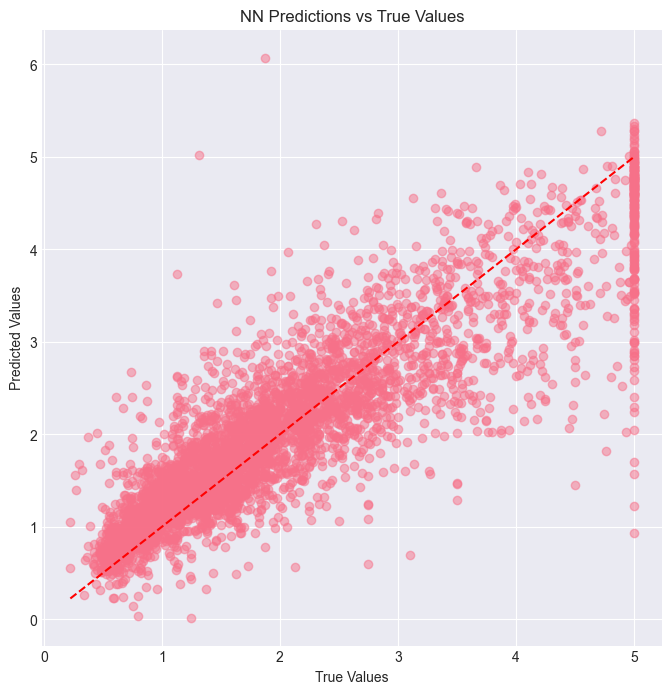

In [144]:
# plot NN predictions vs true values
plt.figure(figsize=(8,8))
plt.scatter(Y_test, Y_pred.cpu().numpy(), alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('NN Predictions vs True Values')
plt.show()

In [147]:
# compare different architectures, learning rates, batch sizes
architectures = [[16, 16], [32, 16], [64, 32, 16]]
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 64, 256]
results = []
for arch in architectures:
    for lr in learning_rates:
        for bs in batch_sizes:
            layers = [nn.Linear(input_size,arch[0]), nn.ReLU()]
            for i,layer in enumerate(arch):
                if i < len(arch) - 1:
                    layers.append(nn.Linear(layer, arch[i+1]))
                    layers.append(nn.ReLU())
            layers.append(nn.Linear(arch[-1], output_size))
            model = nn.Sequential(*layers).to(device)
            print(f'Training model with architecture: {arch}, learning rate: {lr}, batch size: {bs}')
            history = train_model(model, X_train=X_train, Y_train=Y_train, X_val=X_val, Y_val=Y_val, 
                                  num_epochs=200, batch_size=bs, learning_rate=lr)
            model.eval()
            with torch.no_grad():
                X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
                Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).to(device).view(-1, 1)
                Y_pred = model(X_test_tensor)
                test_loss = nn.MSELoss()(Y_pred, Y_test_tensor)
            results.append({
                'Architecture': str(arch),
                'Learning Rate': lr,
                'Batch Size': bs,
                'Test MSE Loss': test_loss.item()
            })

results_df = pd.DataFrame(results)
print(results_df)

Training model with architecture: [16, 16], learning rate: 0.01, batch size: 16
Epoch [1/200], Train Loss: 0.6917, Val Loss: 0.4063
Epoch [2/200], Train Loss: 0.4071, Val Loss: 0.3894
Epoch [3/200], Train Loss: 0.3930, Val Loss: 0.3556
Epoch [4/200], Train Loss: 0.3680, Val Loss: 0.3237
Epoch [5/200], Train Loss: 0.3493, Val Loss: 0.3280
Epoch [6/200], Train Loss: 0.3445, Val Loss: 0.3435
Epoch [7/200], Train Loss: 0.3341, Val Loss: 0.3344
Epoch [8/200], Train Loss: 0.3394, Val Loss: 0.3398
Epoch [9/200], Train Loss: 0.3281, Val Loss: 0.3176
Epoch [10/200], Train Loss: 0.3370, Val Loss: 0.3183
Epoch [11/200], Train Loss: 0.3332, Val Loss: 0.3395
Epoch [12/200], Train Loss: 0.3309, Val Loss: 0.3017
Epoch [13/200], Train Loss: 0.3209, Val Loss: 0.3022
Epoch [14/200], Train Loss: 0.3241, Val Loss: 0.3435
Epoch [15/200], Train Loss: 0.3197, Val Loss: 0.3128
Epoch [16/200], Train Loss: 0.3203, Val Loss: 0.3039
Epoch [17/200], Train Loss: 0.3126, Val Loss: 0.3389
Epoch [18/200], Train Loss: 

KeyboardInterrupt: 